In [137]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lsmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(multcomp))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(export))

# 1. Import data

#### metabolic cage

In [187]:
profile <- read.csv(file = "stat_corrected.csv", as.is = TRUE)
profile$Diet <- as.factor(profile$Diet)
profile$Diet <- factor(profile$Diet, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
profile$MouseID <- ordered(profile$MouseID)
profile$MouseID <- as.factor(profile$MouseID)
head(profile)

,Time,Diet,Cycle,MouseID,EE,EE_30,VO2,VCO2,RQ,VH2O,updateN,uptakeSum,AllMeters,PedMeters,PedSpeed,Walk_pct,Still_pct,Sleep_pct,Sleep_hrs
,<chr>,<fct>,<chr>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Cycle1:06:00-07:00,LFD,light,1,0.5404855,0.2975505,0.9965797,0.9152997,0.9167686,0.04020009,3,0.20799030,27.02899000,22.84515000,0.01516648,58.550800,25.79123,20.48862,0.2050000
2,Cycle1:07:00-08:00,LFD,light,1,0.4461322,0.2490771,0.8381263,0.7600297,0.8984534,0.05141251,0,0.02651143,5.39305100,4.12988300,0.01031982,14.805560,80.66666,79.86111,0.7984722
3,Cycle1:08:00-09:00,LFD,light,1,0.3800183,0.2125851,0.7174721,0.5997670,0.8366441,0.03318607,0,0.00000000,0.00000000,0.00000000,0,0.000000,100.00000,100.00000,1.0002780
4,Cycle1:09:00-10:00,LFD,light,1,0.5073735,0.2677054,0.9626774,0.8178942,0.8478978,0.03901326,3,0.02800667,20.58208000,17.29837000,0.01184387,51.666670,42.36111,33.33333,0.3331944
5,Cycle1:10:00-11:00,LFD,light,1,0.4239801,0.2289626,0.8246741,0.6437418,0.7772089,0.04752724,0,0.00000000,4.49612400,3.24623100,0.008165558,13.718410,86.28159,82.94918,0.8295833
6,Cycle1:11:00-12:00,LFD,light,1,0.3796648,0.1966247,0.7262521,0.5599968,0.7700908,0.03743612,0,0.00000000,0.07000732,0.05000305,0.003620625,0.444321,99.55568,99.55568,0.9955556


#### phenotypes

In [148]:
data <- read.csv("table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = LV_TAG * liver_wt,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces*fecal_tot_output, 
                          rest_fat = Fat_mass - lv_tot_tag/1000 - (TG_feces*fecal_tot_output)/1000 - plasma_TAG*58.5*(wt/1000)/(100*1000))#; head(data)

# 2. Set theme, import functions

#### colors and themes

In [294]:
mycolor <- c("black", "#0080ff", "#ffa500", "red", "darkgreen")
lines <- c("dashed", "solid", "solid", "solid", "solid")
shapes <- c(1, 24, 4, 15, 25)
theme_set(theme_bw())
theme_legend = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=10)),
    plot.title = element_text(size = 15, face = "bold"),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_blank(),
	axis.ticks.x = element_blank(),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "right",
	plot.margin = unit(c(1,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

theme_legend2 = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=10)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_text(size = 13),
	axis.title.x = element_text(size = 15,
                               margin = margin(t=10, r=5, b=0, l=0)),
    plot.title = element_text(size = 15, face = "bold"),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(1,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

theme_legend_free = function(){
	theme(axis.title.y = element_text(size = 15, 
	margin = margin(t=0, r=5, b=0, l=10)),
	axis.text.y = element_text(size = 13),
	axis.text.x = element_blank(),
    plot.title = element_text(size = 15, face = "bold"),
	#axis.ticks.x = element_blank(),
	legend.title = element_text(colour = "white"),
	legend.text = element_text(size = 16),
	legend.position = "none",
	plot.margin = unit(c(1,0.5,0,0.5), "cm"),
	panel.grid = element_blank())
}

In [31]:
Contrasts <- list(
    'TXN vs HFD' = c(0, -1, 0, 0, 1),
    'HXN vs HFD' = c(0, -1, 0, 1, 0),
    'LFD vs HFD' = c(1, -1, 0, 0, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(0, -1, 1, 0, 0))

Contrasts1 <- list(
    'HFD vs LFD' = c(-1, 1, 0, 0, 0),
    'LXN vs LFD' = c(-1, 0, 1, 1, 0),
    'HXN vs LFD' = c(-1, 0, 0, 1, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'TXN vs HFD' = c(0, -1, 0, 0, 1))


median_RQ_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="light")
median_RQ_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="dark")

median_EE_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="light")
median_EE_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="dark")

In [150]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

pearson.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="pearson")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="pearson")$estimate))
  names(coeff) <- "rho"
  result <- list(method="pearson correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

#### ggplotRegression

In [280]:
ggplotRegression2 <- function (fit, cols) {
    
    ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
          geom_point(size = 4, color = cols, alpha = 0.6) +
          stat_smooth(method = "lm", col = "black", geom = "smooth", fill = "#303F9F", alpha = 0.2) +
          labs(subtitle = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 3),
                                " P =",signif(summary(fit)$coef[2,4], 3))) #+
          #theme(axis.title = element_text(size= 20, face = 'bold'),
          #axis.text = element_text(size = 18))
}

# 3. EE & Cal

## 3.1 Average energy expenditure

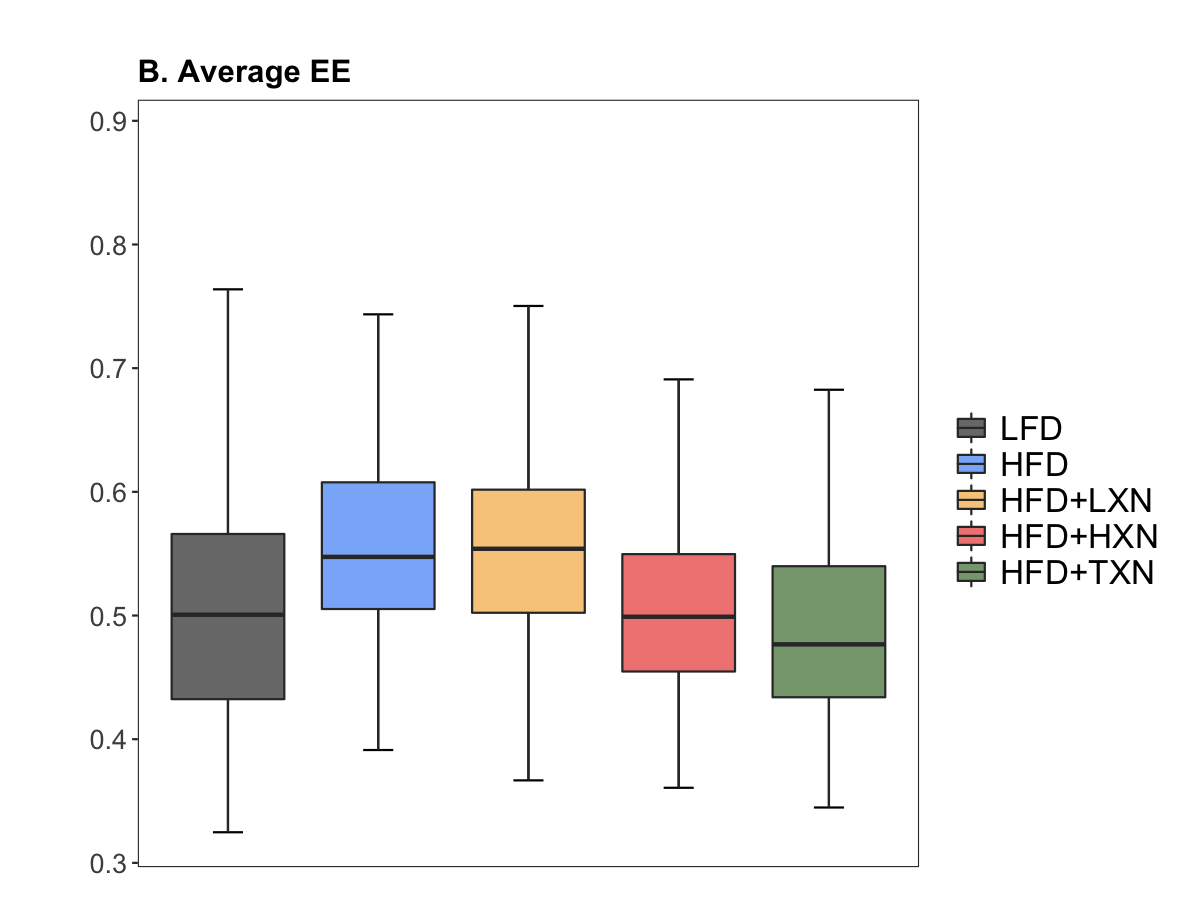

In [359]:
eebox <- profile %>% dplyr::select(1:5) %>% group_by(Diet, Cycle)

f <- function(x){
  r <- quantile(x, probs = c(0.10, 0.25, 0.5, 0.75, 0.90))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

o <- function(x){
  subset(x, x < quantile(x, probs = 0.1) | quantile(x, probs = 0.9) < x)
}

#eeboxp <- ggplot(data=eebox, aes(x=Diet, y=EE, fill=Diet)) +
#    stat_summary(fun.data = f, geom = "boxplot", position = "dodge") +
 #   scale_fill_manual(values = alpha(mycolor, .6)) +
#    labs(x="", y="", title = "B")
    #facet_grid(~ Cycle) 

mycolor2 <- c("#797979", "#8AB5F9", "#F8CB89", "#F08581", "#87A57E")
eeboxp <- ggplot(data = eebox, aes(x = Diet, y = EE, fill = Diet)) +
    stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
    geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor2) +
    #geom_jitter(shape = 4, size = 3, width = 0.2, height = 0.1) +
    labs(x = '', y = '', title = "B. Average EE")

options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150)
(eeboxp <- eeboxp + 
    theme_legend())

## 3.2 Hourly energy expenditure

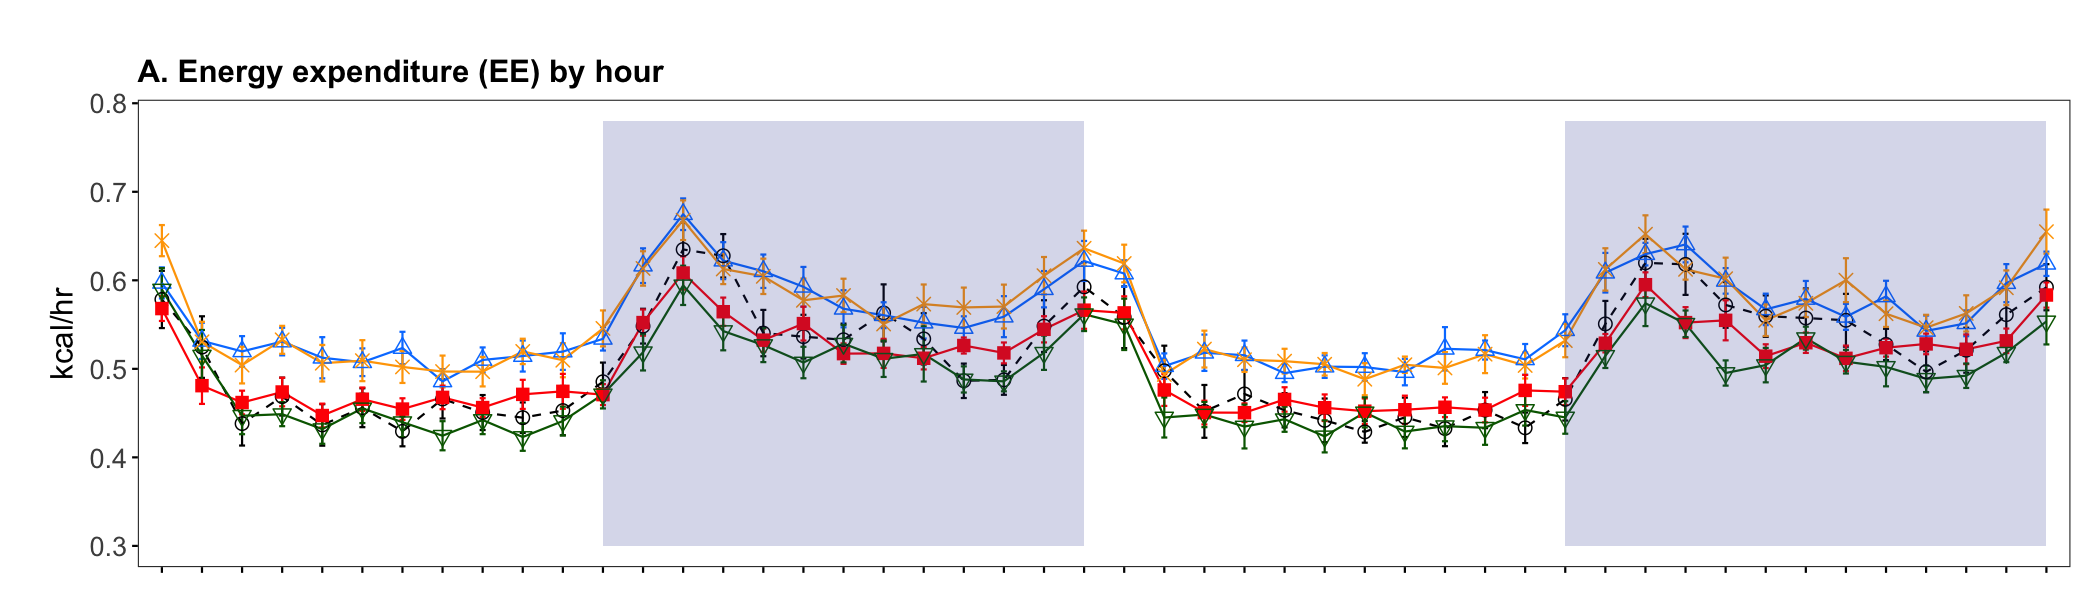

In [358]:
EE <- ggline(profile, x = "Time", y = "EE", group = "Diet",
       add = "mean_se", color = "Diet", palette = mycolor,
       ylab = "kcal/hr", xlab = "", 
       linetype = "Diet", shape = "Diet",
       point.size = 1.5,
       ggtheme = theme_bw())


EE <- EE + 
    annotate("rect", xmin="Cycle1:17:00-18:00", xmax="Cycle1:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F") +
    annotate("rect", xmin="Cycle2:17:00-18:00", xmax="Cycle2:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F")

options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)

(EE <- EE + scale_linetype_manual(values=c("dashed", "solid", "solid", "solid", "solid")) +  
    scale_shape_manual(values = shapes) +
    labs(title = "A. Energy expenditure (EE) by hour")+
    theme_legend_free())

In [360]:
parA <- (EE | eeboxp) + plot_layout(widths = c(2.5,1))

In [361]:
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)
##########################################################################################

lfd_EE_cal <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = lfd), "black") + 
                labs(title = "C. Average EE and Caloric Intake", x = "", y = "Average energy expenditure")+ theme_legend2()
hfd_EE_cal <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = hfd), "#0080ff")+ 
                labs(title = "", x = "", y = "")+ theme_legend2()
txn_EE_cal <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = txn), "darkgreen")+ 
                labs(title = "", x = "", y = "")+ theme_legend2()

##########################################################################################
parB <- (lfd_EE_cal | hfd_EE_cal | txn_EE_cal)

parB[[2]] = parB[[2]] + theme(axis.text.y = element_blank(),
                                        axis.ticks.y = element_blank(),
                                        axis.title.y = element_blank())

parB[[3]] = parB[[3]] + theme(axis.text.y = element_blank(),
                                        axis.ticks.y = element_blank(),
                                        axis.title.y = element_blank())
#lxn_EE_cal <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = lxn), "yellow")+ ggtitle("LXN")+ theme_legend2()
#hxn_EE_cal <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = hxn), "red")+ ggtitle("HXN")+ theme_legend2()

#### Fig

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



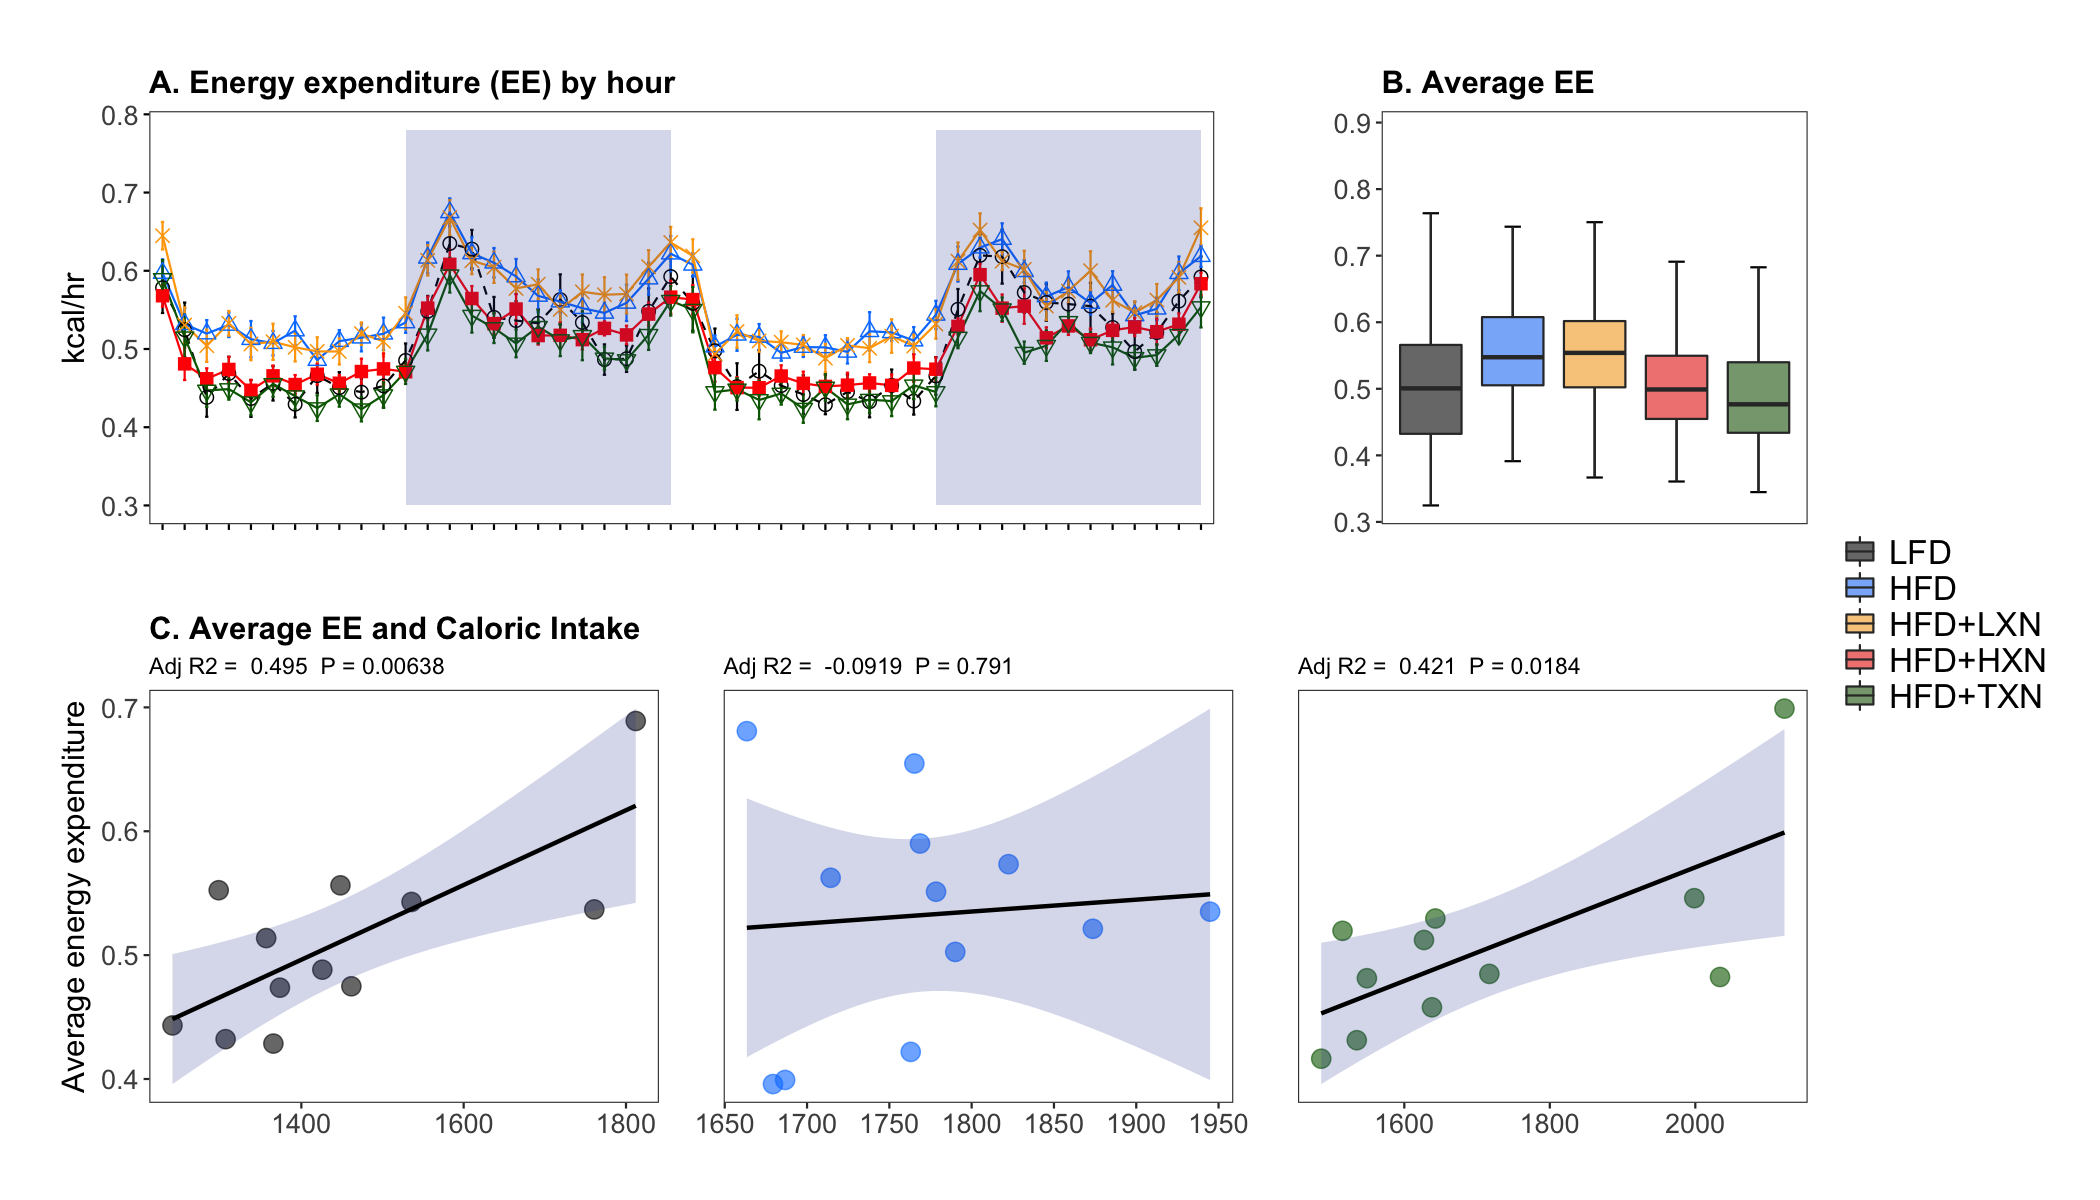

In [362]:
options(repr.plot.width = 14, repr.plot.height = 8, repr.plot.res = 150)
(ee_cal <- parA / parB)+ plot_layout(heights = c(1,1), guides = 'collect')

In [22]:
#graph2pdf(EE, "EE.pdf", width = 16, height = 8)

# 4. Fat mass & Cal

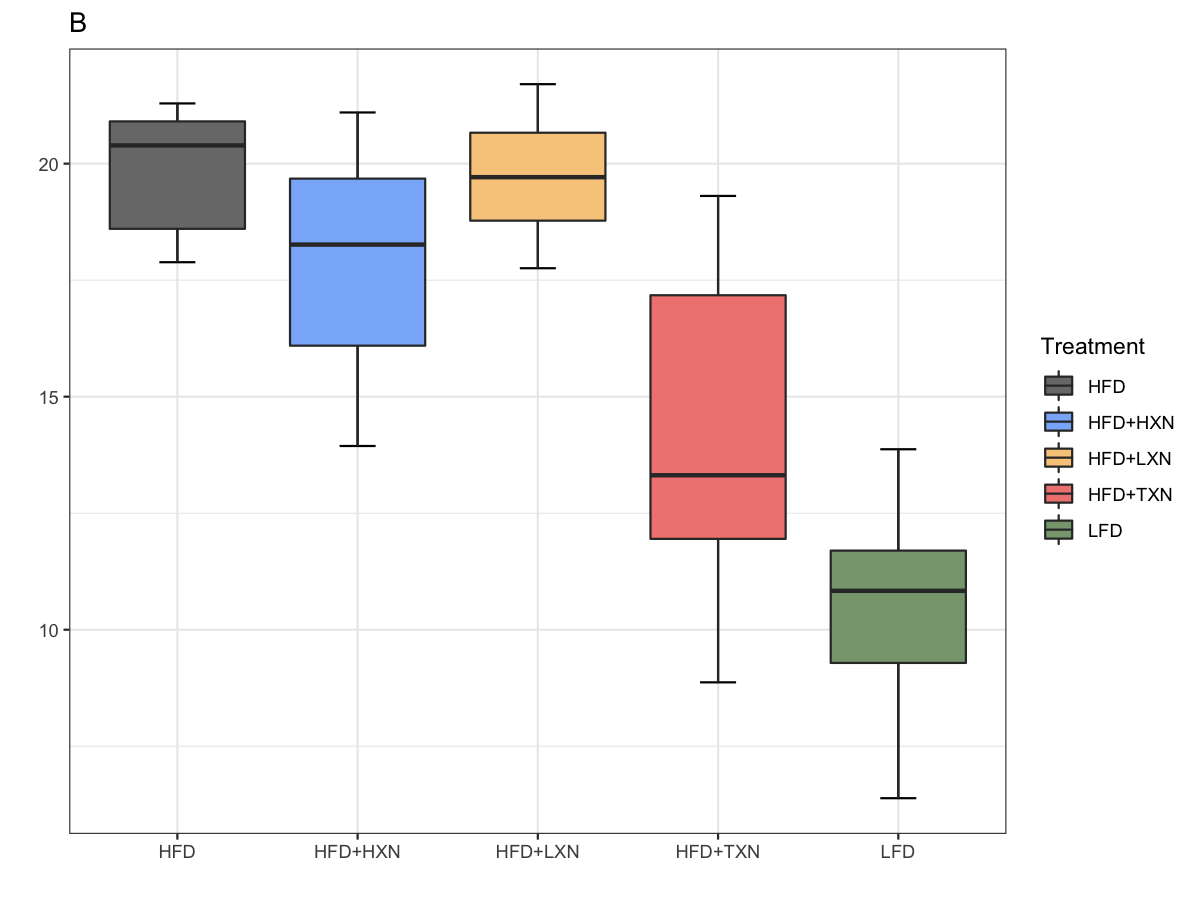

In [316]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150)
ggplot(data = data, aes(x = Treatment, y = Fat_mass, fill = Treatment)) +
    stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
    geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor2) +
    #geom_jitter(shape = 4, size = 3, width = 0.2, height = 0.1) +
    labs(x = '', y = '', title = "B")




In [363]:
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)
##########################################################################################

lfd_fat_cal <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = lfd), "black") + 
                labs(title = "D. Fat mass and caloric intake", x = "", y = "Fat mass (g)")+ theme_legend2()
hfd_fat_cal <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = hfd), "#0080ff")+ 
                labs(title = "", x = "", y = "")+ theme_legend2()
txn_fat_cal <- ggplotRegression2(lm(Fat_mass ~ Cal_cum, data = txn), "darkgreen")+ 
                labs(title = "", x = "", y = "")+ theme_legend2()

##########################################################################################
fat <- (lfd_fat_cal | hfd_fat_cal | txn_fat_cal)

In [364]:
options(repr.plot.width = 14, repr.plot.height = 4, repr.plot.res = 150)
##########################################################################################

lfd_lipidosis_area_pct_cal <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = lfd), "black") + 
                labs(title = "E. Steatosis and caloric intake", x = "LFD", y = "Lipidosis Area Percent (%)")+ theme_legend2()
hfd_lipidosis_area_pct_cal <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = hfd), "#0080ff")+ 
                labs(title = "", x = "Cumulative Caloric Consumption", y = "")+ theme_legend2()
txn_lipidosis_area_pct_cal <- ggplotRegression2(lm(lipidosis_area_pct ~ Cal_cum, data = txn), "darkgreen")+ 
                labs(title = "", x = "HFD+TXN", y = "")+ theme_legend2()

##########################################################################################
lipid <- (lfd_lipidosis_area_pct_cal | hfd_lipidosis_area_pct_cal | txn_lipidosis_area_pct_cal)

In [367]:
options(repr.plot.width = 13, repr.plot.height = 12, repr.plot.res = 150)
figure <- (ee_cal / fat / lipid)+ plot_layout(nrow = 4, heights = c(1.5,1,1,1), guides = 'collect')

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



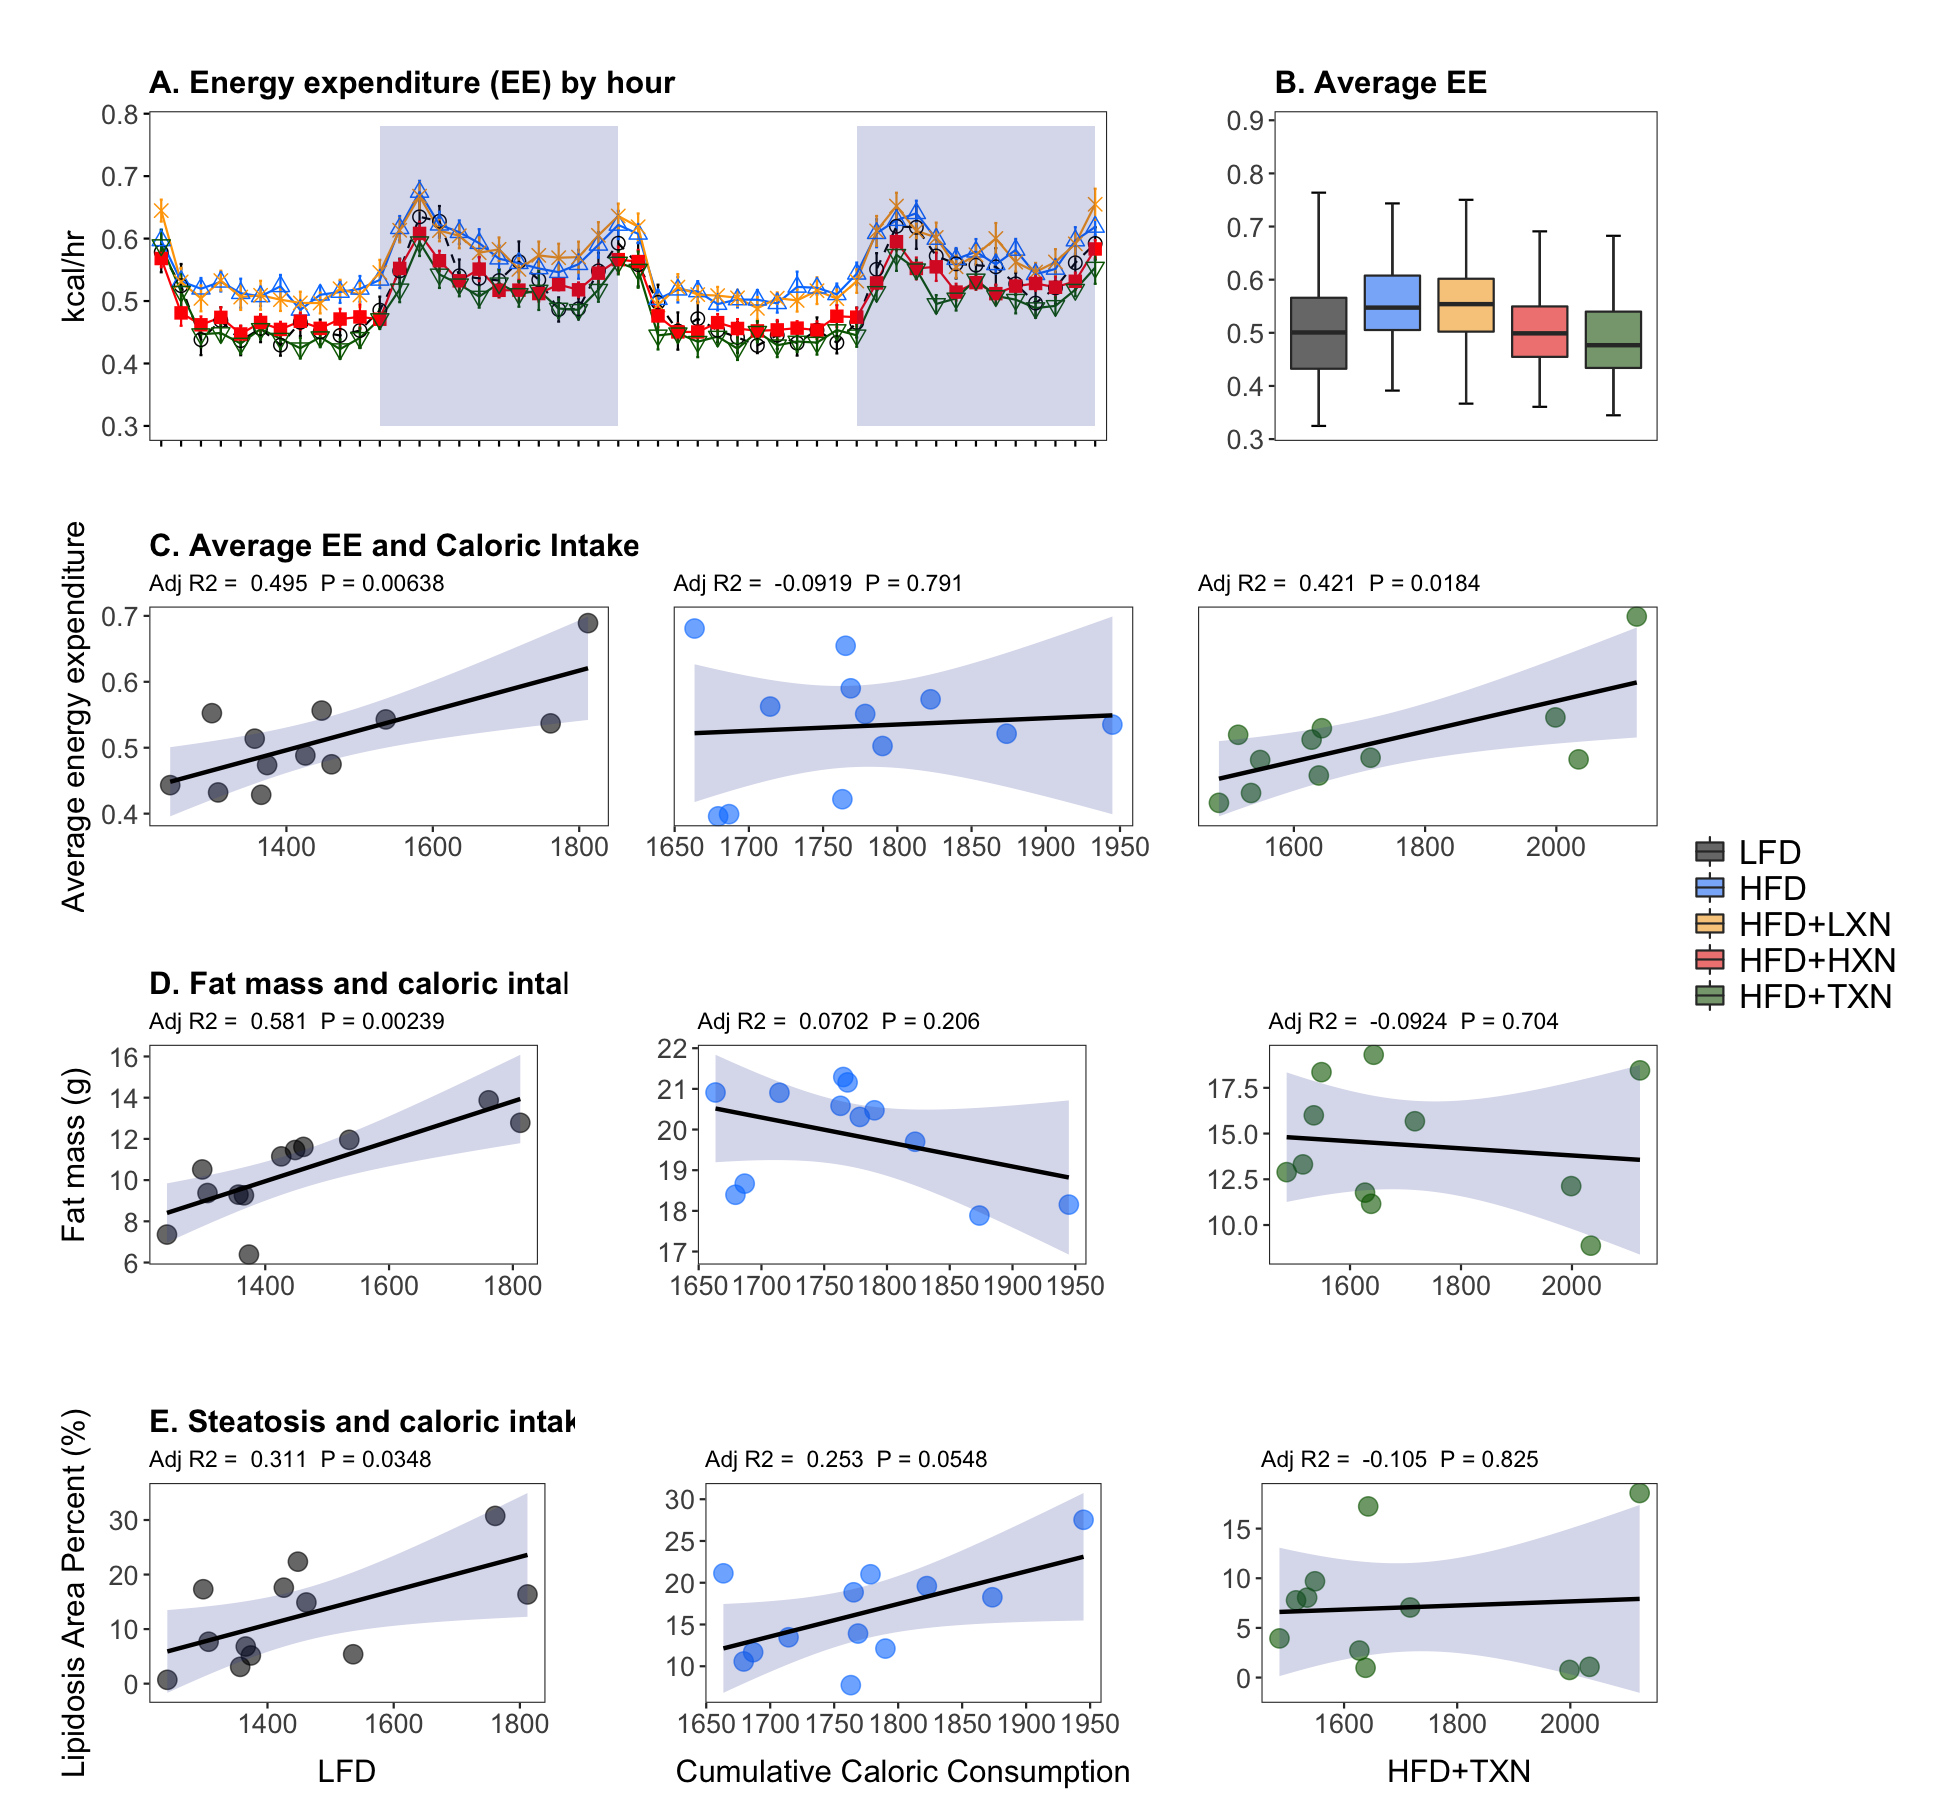

In [368]:
figure

In [352]:
graph2pdf(figure, "figure.pdf", width = 15, height = 13)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Exported graph as figure.pdf



# 4. Stats

## 4.1 Average energy expenditure

In [51]:
model_lt <- lm(medEE ~ Diet, data=median_EE_lt)
leastsquare <- lsmeans(model_lt, "Diet")
output <- contrast(leastsquare, Contrasts, adjust = "none")
print(output)

 contrast   estimate     SE df t.ratio p.value
 TXN vs HFD -0.07218 0.0212 54 -3.412  0.0012 
 HXN vs HFD -0.04972 0.0207 54 -2.403  0.0197 
 LFD vs HFD -0.05824 0.0207 54 -2.815  0.0068 
 TXN vs LFD -0.01393 0.0212 54 -0.659  0.5129 
 LXN vs HFD -0.00111 0.0207 54 -0.053  0.9575 



## 4.2 Correlations

> 4.1 shows that LFD, HXN and TXN had lower average energy expenditure compared to HFD mice. This makes intuitive sense because usually the larger the animal, the more energy is spent. I did a correlation analysis with total body weight just to see what it looks like. And I excluded LFD from this analysis.

In [74]:
dataHFD <- data %>%
filter(Treatment != "LFD")

In [75]:
dataHFD %>%
    summarise(r = pearson.ci(avgEE, wt)$estimate,
             pvalue = cor.test(avgEE, wt, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, wt)$conf.int[1],
             upper = pearson.ci(avgEE, wt)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.6625921,3.905908e-07,0.52924,0.7834008


> A strong and significant positive correlation between total body weight and average energy expenditure.

In [76]:
dataHFD %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(avgEE, wt)$estimate,
             pvalue = cor.test(avgEE, wt, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, wt)$conf.int[1],
             upper = pearson.ci(avgEE, wt)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.7254564,0.007577621,0.4021262,0.9109864
HFD+LXN,0.3245957,0.303291183,-0.4148636,0.7481900
HFD+HXN,0.5903490,0.043293600,0.1630357,0.8150822
HFD+TXN,0.6401284,0.033882418,-0.1225383,0.8991974


> In general, the relationship holds true in HFD, HXN and TXN groups, except for LXN.

## 4.2 ANCOVA analysis on Average energy expenditure, controlling for total body weight

> Obviously, body weight is one of the key factors driving the rate of energy expenditure. Bigger mice have more metabolizing tissue and expend more energy. Even if a difference is detected in the rate of energy expenditure shown in 4.1, it may be a secondary effect of the altered body weight, rather than a primary effect of the treatment alone. My first thought was to normalize energy expenditure with body weight. After some researching, I realized that approach can be problematic, because the relationship between metabolic rate and body weight is seldom proportional.
> **Therefore, analysis of covariance, in my opinion, can give me the answer whether or not the treatment had any effect on the energy expenditure.**

ref: https://paperpile.com/app/p/ad2144a3-3bc8-0c95-acc5-27e3db62202a

> Analysis of Covariance (ANCOVA) is a parametric test that examines whether there are significant differences among groups of a categorical variable while controlling for the variation in a continuous covariate (continuous explanatory variable). It combines linear regression and ANOVA and tests whether the slopes of each line for each categorical explanatory variable are significantly different from each other. ANCOVA has two sampling variability assumptions that have to be met:
> 1. The residuals have to be normally distributed;
> 2.    There is equal variance among groups (homogeneity of variance).


Before we can interpret our statistical output, we need to make sure the assumptions above are met.

https://www.rpubs.com/cwoods/ancova

In [103]:
ancova <- lm(avgEE~Treatment*wt, dataHFD)

### 4.2.1 a density plot of residuals and a Q-Q plot to see whether the residuals are normally distributed

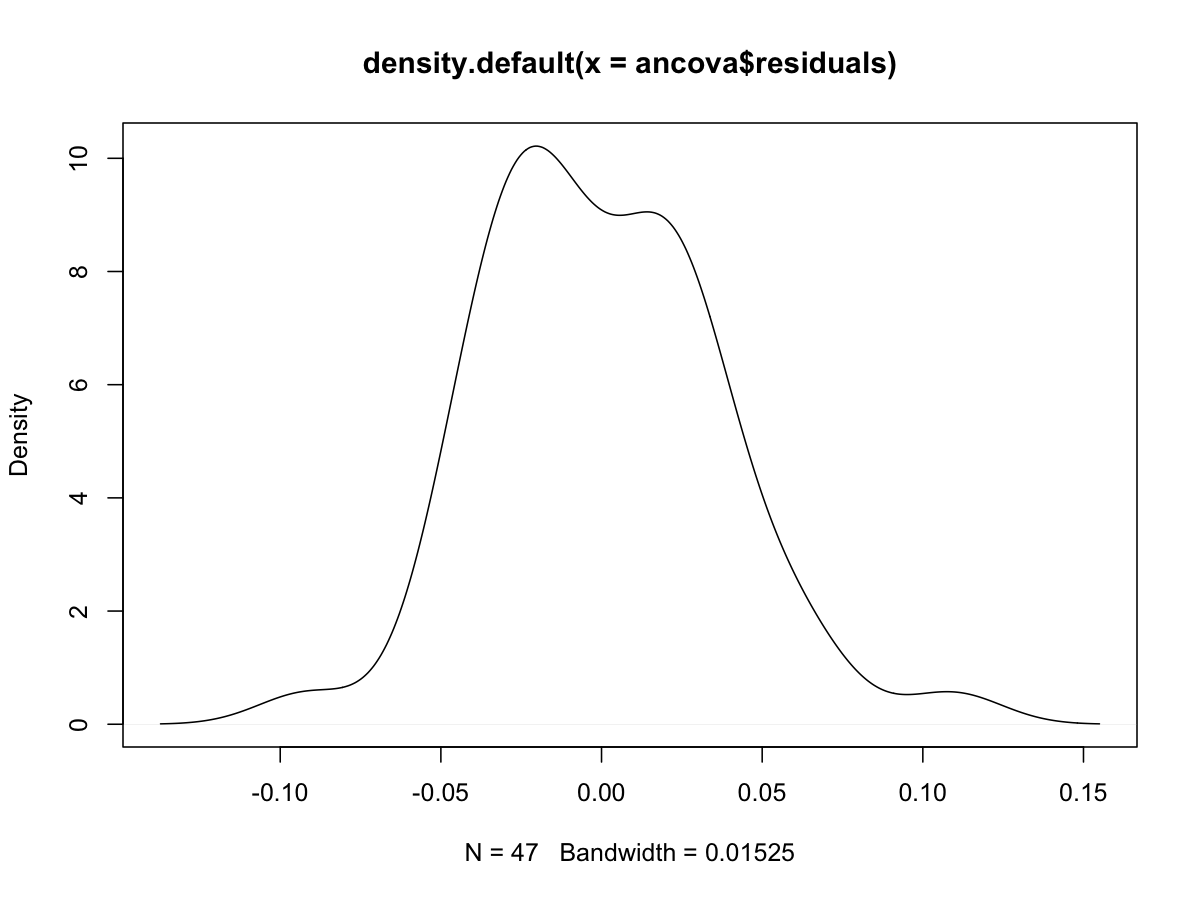

In [94]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150)
plot(density(ancova$residuals))

> Does it look normal? There's a tiny shoulder there. Is it bimodal?

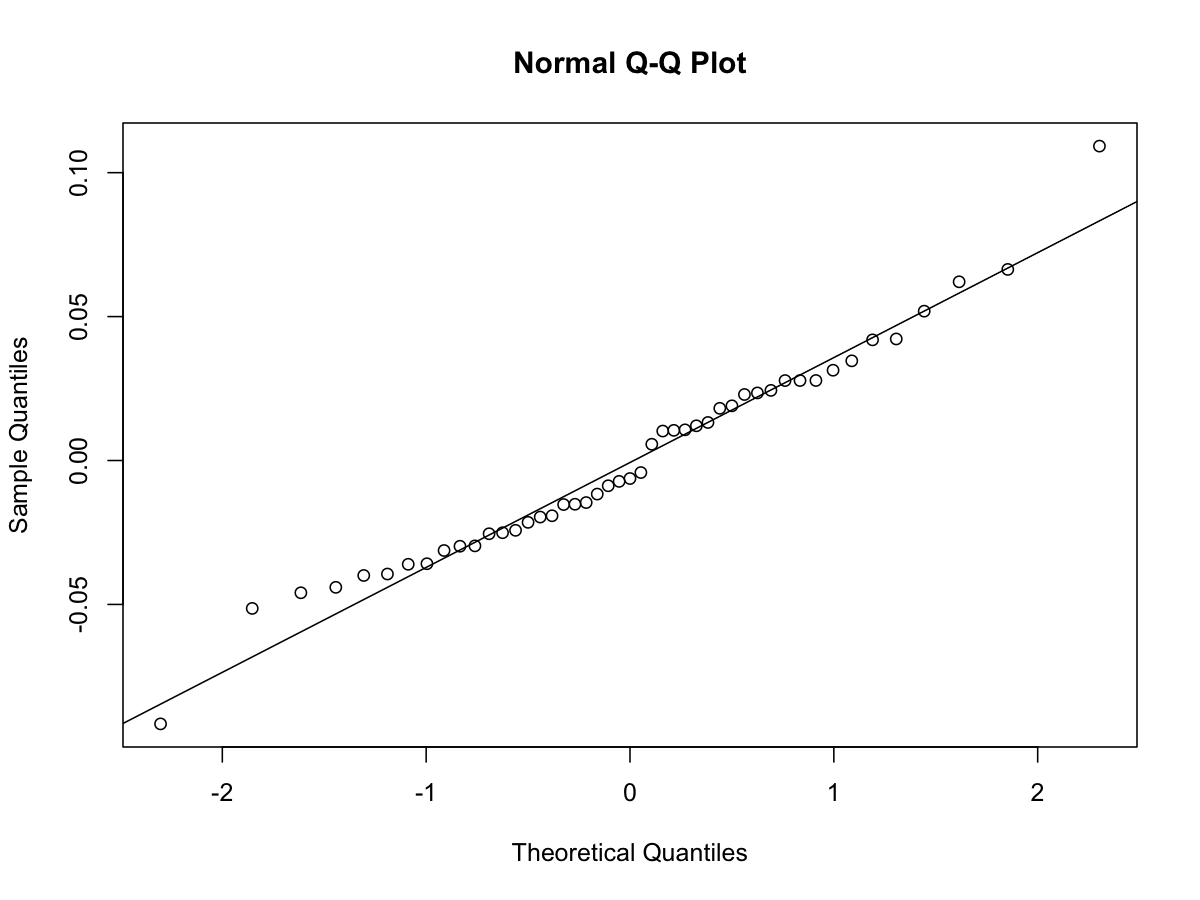

In [96]:
qqnorm(ancova$residuals)
qqline(ancova$residuals, datax = FALSE, distribution = qnorm, probs = c(0.25, 0.75))

> Q-Q plot looks pretty good to me. I think the data is pretty normal.

### 4.2.2 a plot of fitted values vs. residuals, looking for patterns

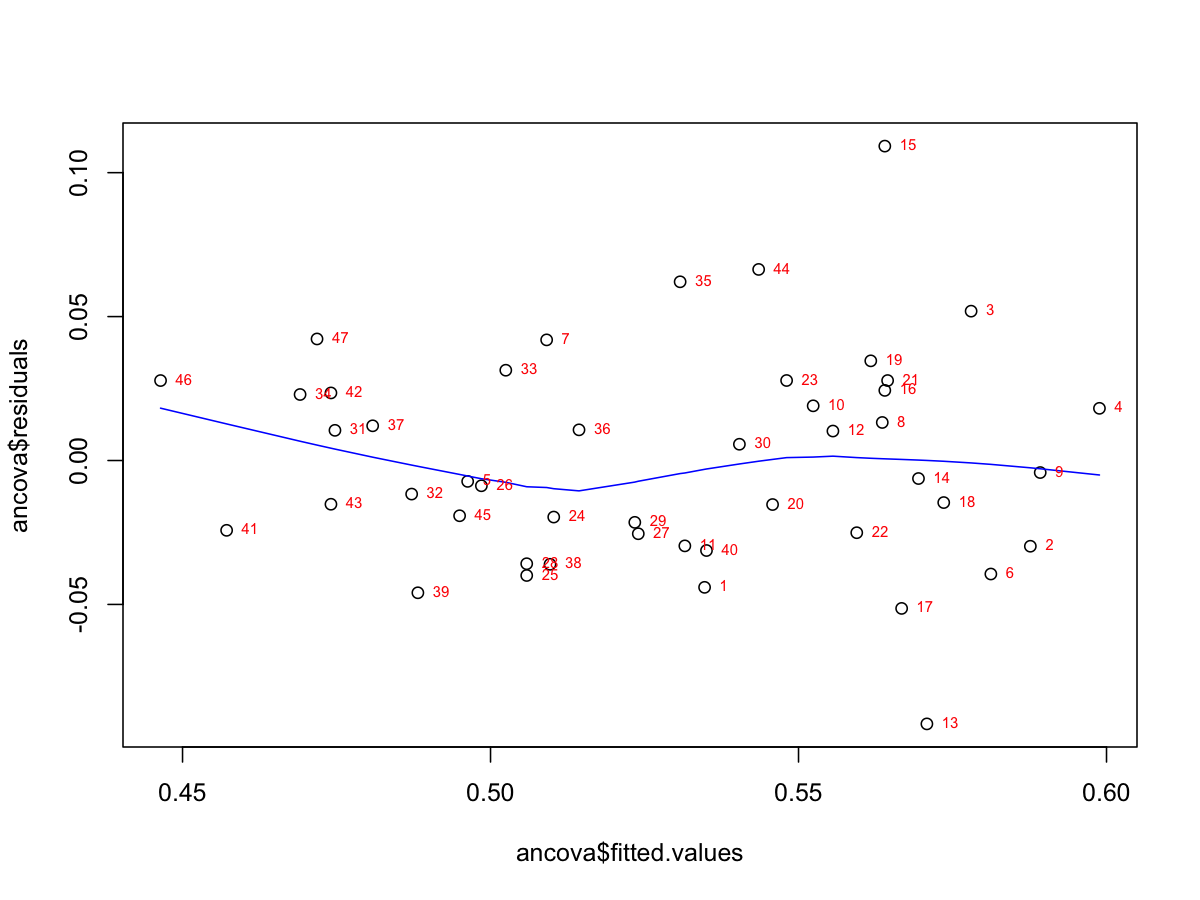

In [98]:
plot(ancova$residuals~ancova$fitted.values)
lines(lowess(ancova$fitted.values,ancova$residuals), col="blue")
text(ancova$fitted.values, ancova$residuals, row.names(dataHFD), cex=0.6, pos=4, col="red")

> I see no pattern here, so the variation is homogeneous and no transformation is needed.

### 4.2.3 Interpreting ANCOVA output

In [131]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(avgEE, Cal_cum)$estimate,
             pvalue = cor.test(avgEE, Cal_cum, method = "spearman")$p.value,
             lower = spearman.ci(avgEE, Cal_cum)$conf.int[1],
             upper = spearman.ci(avgEE, Cal_cum)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
LFD,0.53146853,0.079302939,-0.09629630,0.9142857
HFD,0.03496503,0.921184083,-0.73076923,0.7785714
HFD+LXN,0.81818182,0.002027199,0.47857143,0.9565217
HFD+HXN,0.27272727,0.391232746,-0.41935484,0.8932384
HFD+TXN,0.61818182,0.047816905,-0.08653846,0.9710145


In [167]:
txn <- data %>% filter(vars == "HFD+TXN"); hfd <- data %>% filter(vars == "HFD");
lxn <- data %>% filter(vars == "HFD+LXN"); hxn <- data %>% filter(vars == "HFD+HXN");
lfd <- data %>% filter(vars == "LFD")

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



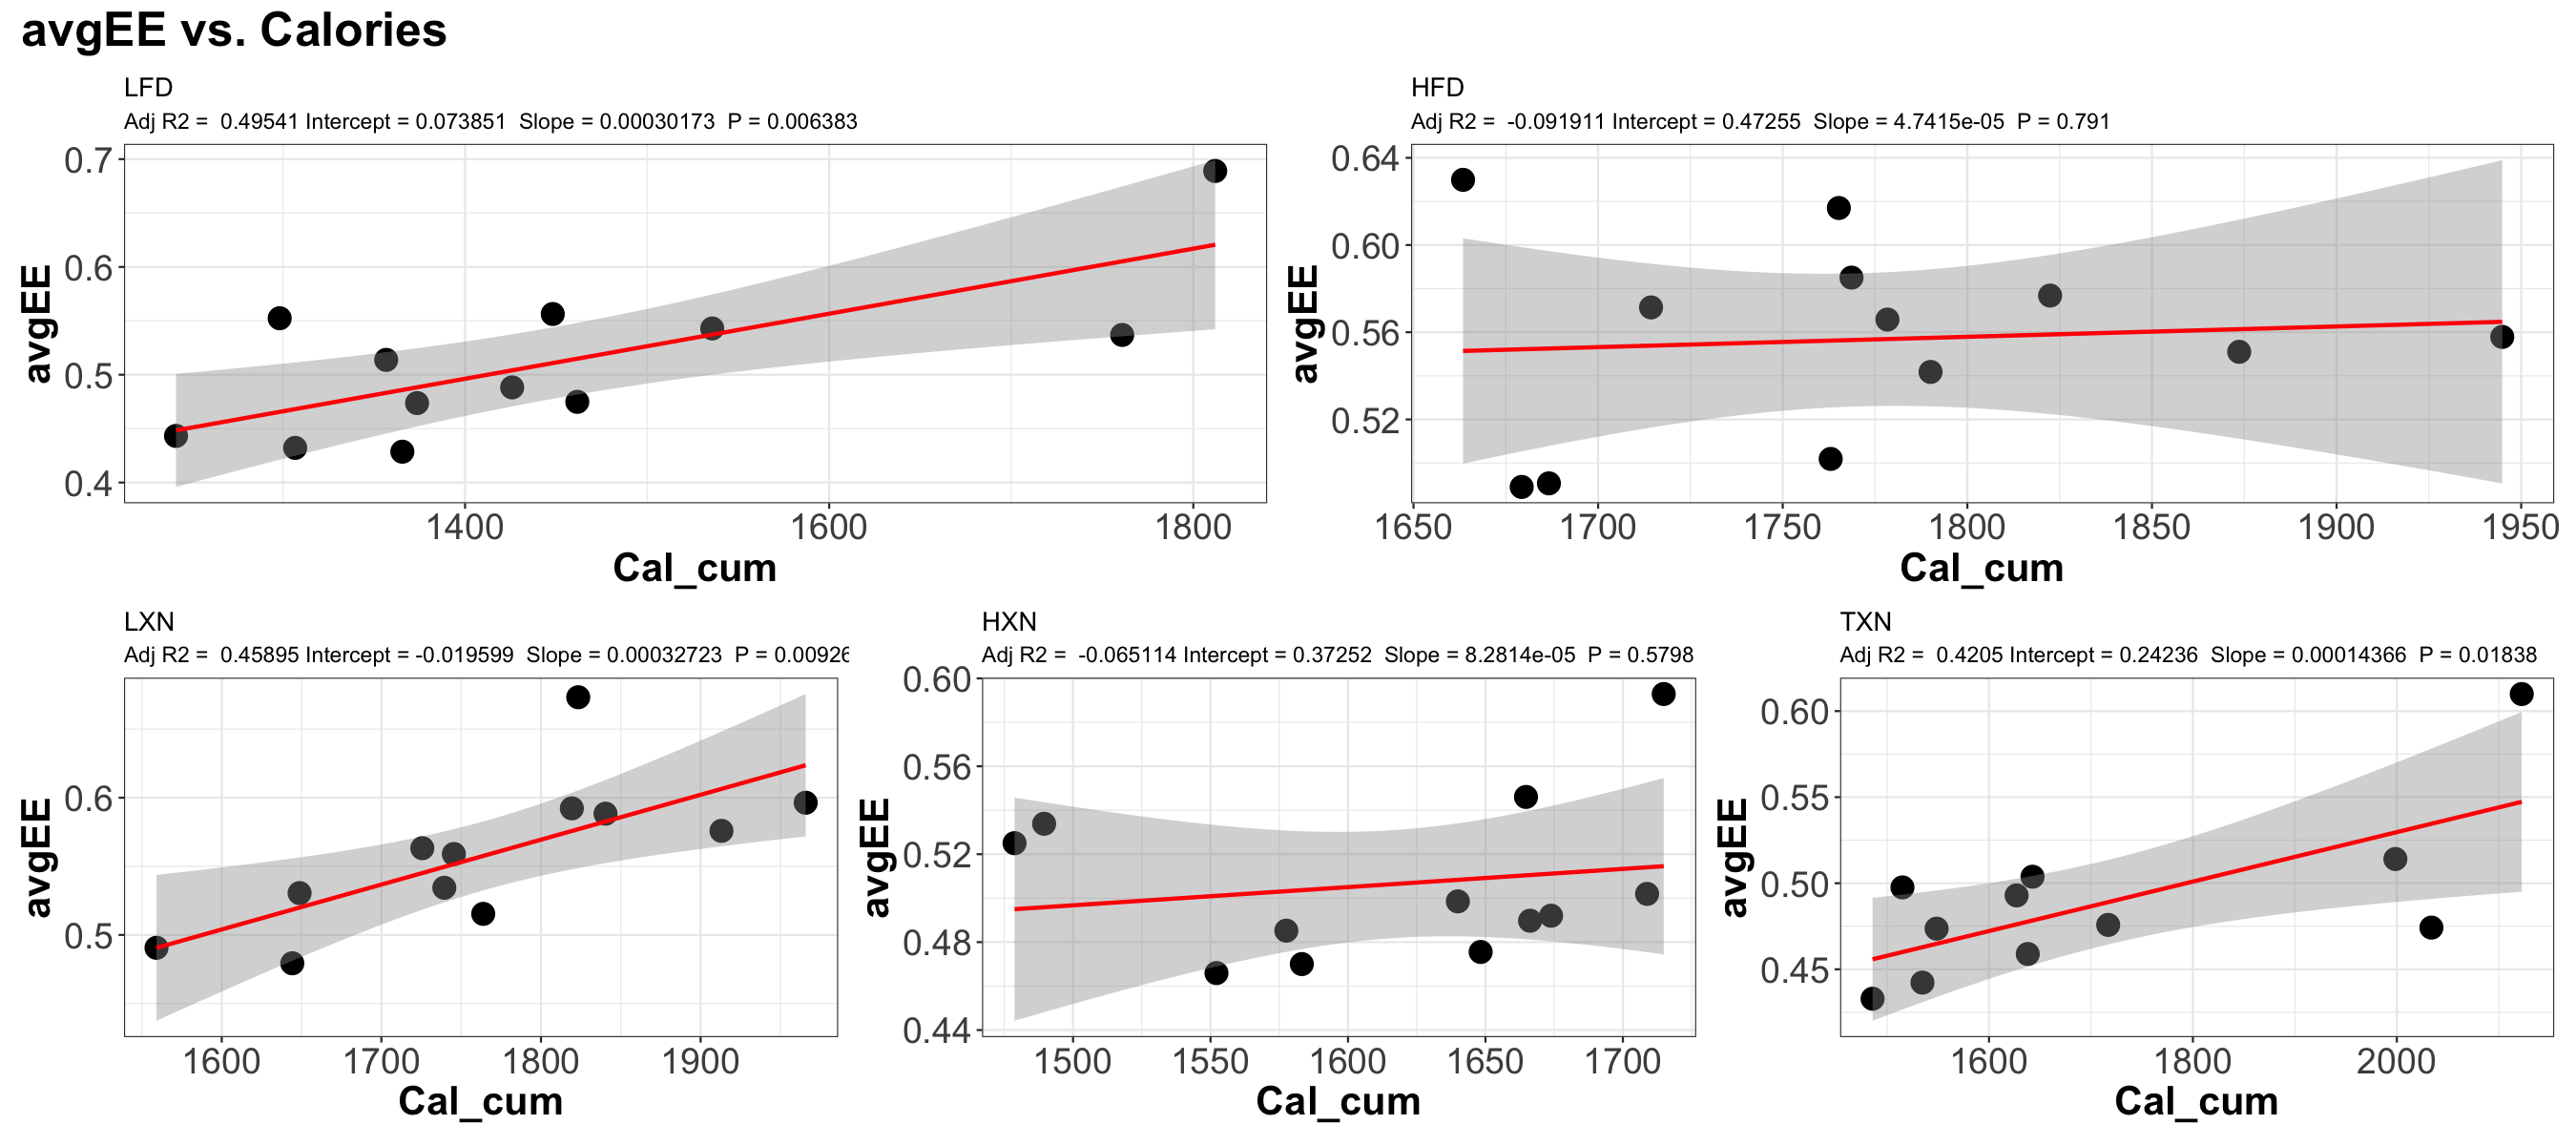

In [144]:
options(repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 150)
lfd_steatosis <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = lfd)) + ggtitle("LFD")
hfd_steatosis <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = hfd))+ ggtitle("HFD")
lxn_steatosis <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = lxn))+ ggtitle("LXN")
hxn_steatosis <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = hxn))+ ggtitle("HXN")
txn_steatosis <- ggplotRegression2(lm(avgEE ~ Cal_cum, data = txn))+ ggtitle("TXN")
(lfd_steatosis | hfd_steatosis) / (lxn_steatosis |hxn_steatosis | txn_steatosis) + 
plot_annotation(title = 'avgEE vs. Calories', 
                theme = theme(title = element_text(size = 20, face = 2)))

In [100]:
anova(ancova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.043276716,0.014425572,9.134502,0.000104931
wt,1,0.024609603,0.024609603,15.583193,0.000320243
Treatment:wt,3,0.005049408,0.001683136,1.065789,0.374710820
Residuals,39,0.061590363,0.001579240,NA,NA


> This output shows that the interaction term is not significant. That means that body weight influences energy expenditure **independent of the treatment**.

> Energy expenditure increased significantly as body weight increased (ANCOVA, F = 15.58, df = 1?, p < 0.001 ). This pattern was similar for different XN treatments (F = 9.13, df = 3, p < 0.001 ). The relationship between energy expenditure and body weight is independent on treatment (ANCOVA, F = 1.07, df = 3, p = 0.37).

In [116]:
ancova2 <- lm(avgEE~Treatment*Lean_mass*Fat_mass, dataHFD)

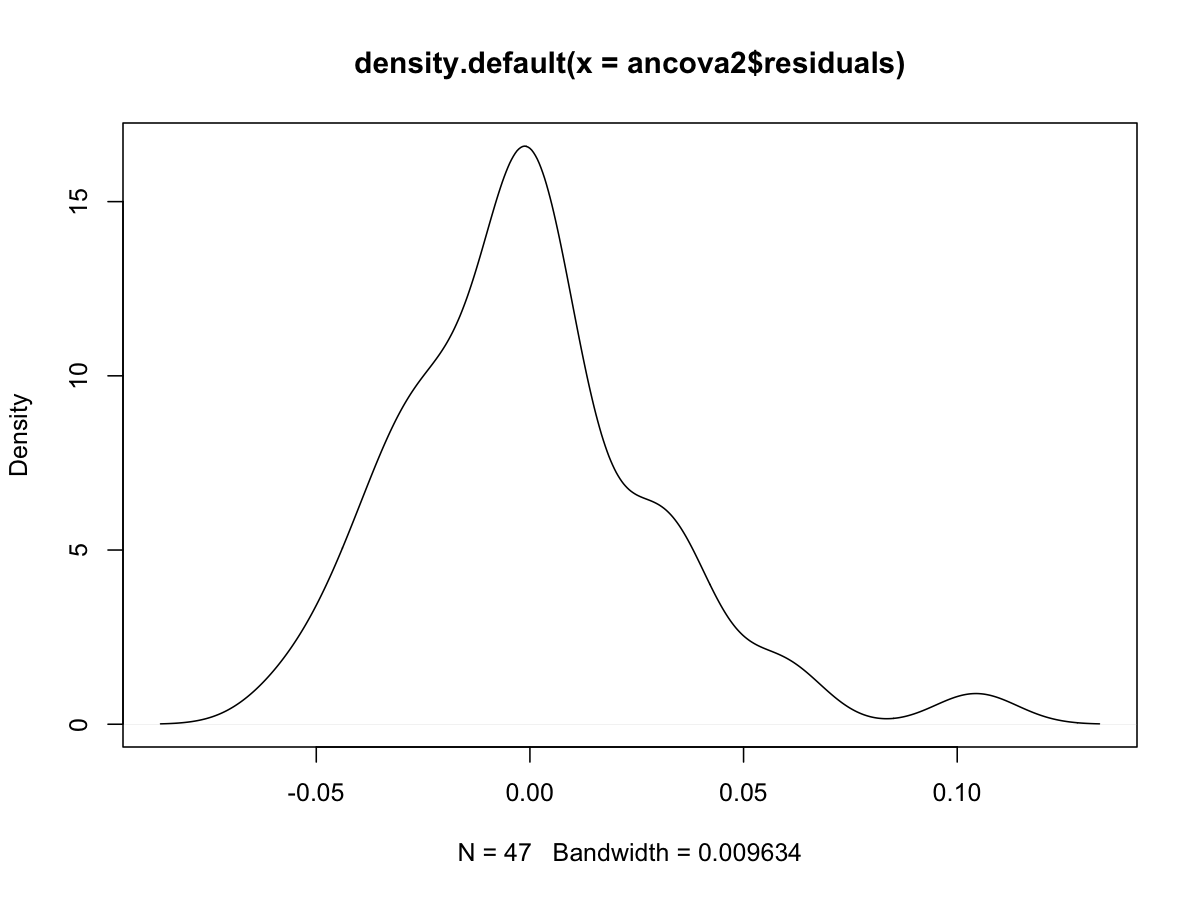

In [117]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 150)
plot(density(ancova2$residuals))

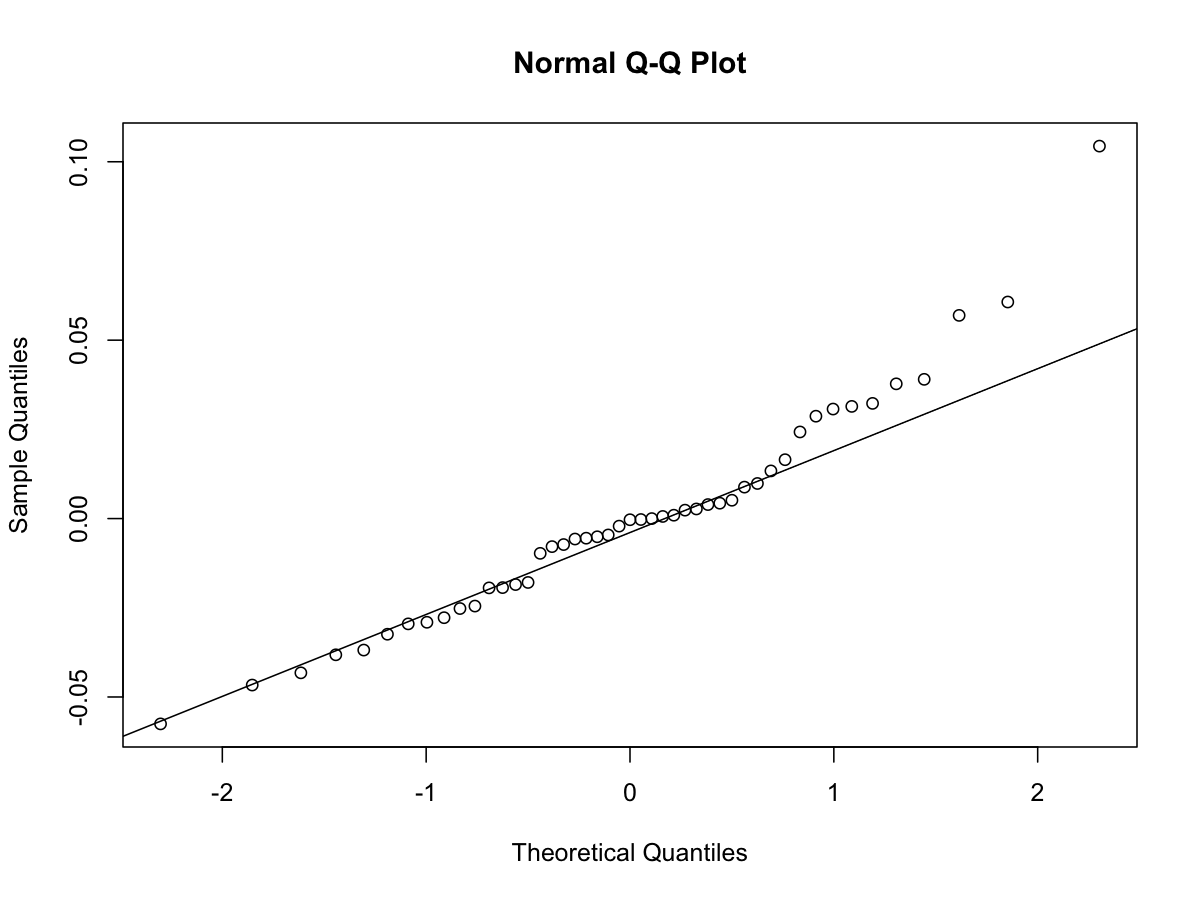

In [118]:
qqnorm(ancova2$residuals)
qqline(ancova2$residuals, datax = FALSE, distribution = qnorm, probs = c(0.25, 0.75))

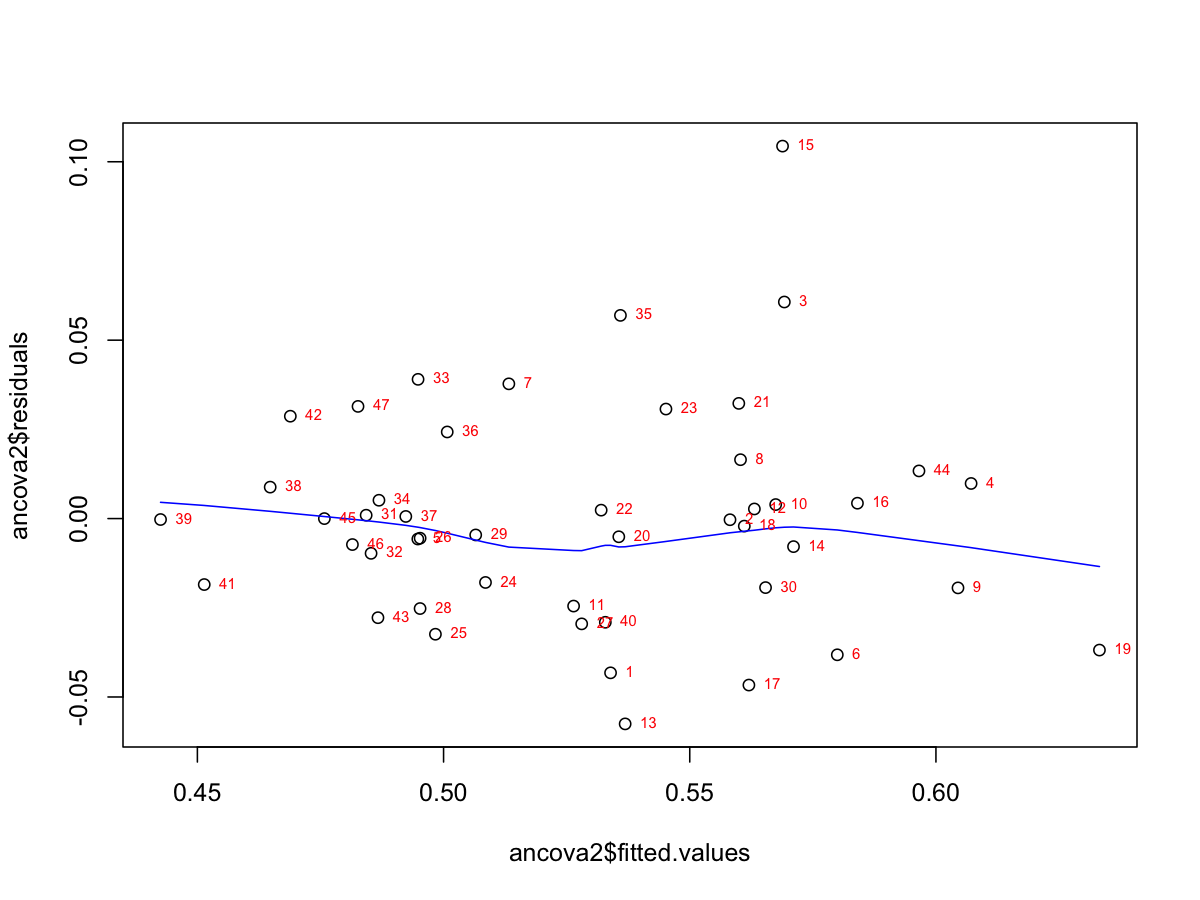

In [119]:
plot(ancova2$residuals~ancova2$fitted.values)
lines(lowess(ancova2$fitted.values,ancova2$residuals), col="blue")
text(ancova2$fitted.values, ancova2$residuals, row.names(dataHFD), cex=0.6, pos=4, col="red")

In [120]:
anova(ancova2)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.043276716,0.0144255719,10.5118470,6.277741e-05
Lean_mass,1,0.034920119,0.0349201189,25.4461278,1.891052e-05
Fat_mass,1,0.001364450,0.0013644496,0.9942680,3.264215e-01
Treatment:Lean_mass,3,0.001484777,0.0004949257,0.3606500,7.818137e-01
Treatment:Fat_mass,3,0.005962713,0.0019875710,1.4483338,2.477372e-01
Lean_mass:Fat_mass,1,0.001432469,0.0014324689,1.0438334,3.148389e-01
Treatment:Lean_mass:Fat_mass,3,0.003543062,0.0011810208,0.8606044,4.718449e-01
Residuals,31,0.042541784,0.0013723156,NA,NA


In [125]:
ancova3 <- lm(avgEE~Treatment*Lean_mass*epi_wat*subq_wt, dataHFD)

In [126]:
anova(ancova3)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.0432767156,0.0144255719,9.7249241,0.0008226078
Lean_mass,1,0.0349201189,0.0349201189,23.5412163,0.0002112733
epi_wat,1,0.0055018162,0.0055018162,3.7090208,0.0732887083
subq_wt,1,0.0023136794,0.0023136794,1.5597549,0.2308410067
Treatment:Lean_mass,3,0.0046174798,0.0015391599,1.0376167,0.4043074896
Treatment:epi_wat,3,0.0004504466,0.0001501489,0.1012221,0.9580667983
Lean_mass:epi_wat,1,0.0001738965,0.0001738965,0.1172314,0.7368073545
Treatment:subq_wt,3,0.0029903095,0.0009967698,0.6719672,0.5823940841
Lean_mass:subq_wt,1,0.0002880768,0.0002880768,0.1942054,0.6657241536


In [77]:
fit = aov(avgEE~Treatment+wt, dataHFD)

In [78]:
Anova(fit, type="III")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.015751092,1,9.927193,0.002999633
Treatment,0.008825554,3,1.854114,0.152108433
wt,0.024609603,1,15.510307,0.000303563
Residuals,0.066639771,42,NA,NA


In [79]:
summary(Anova(fit, type="III"))

     Sum Sq               Df           F value           Pr(>F)         
 Min.   :0.008826   Min.   : 1.00   Min.   : 1.854   Min.   :0.0003036  
 1st Qu.:0.014020   1st Qu.: 1.00   1st Qu.: 5.891   1st Qu.:0.0016516  
 Median :0.020180   Median : 2.00   Median : 9.927   Median :0.0029996  
 Mean   :0.028957   Mean   :11.75   Mean   : 9.097   Mean   :0.0518039  
 3rd Qu.:0.035117   3rd Qu.:12.75   3rd Qu.:12.719   3rd Qu.:0.0775540  
 Max.   :0.066640   Max.   :42.00   Max.   :15.510   Max.   :0.1521084  
                                    NA's   :1        NA's   :1          

In [80]:
posth = glht(fit, linfct=mcp(Treatment='Tukey'))
summary(posth)
emmeans(fit, ~ Treatment:wt)


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = avgEE ~ Treatment + wt, data = dataHFD)

Linear Hypotheses:
                        Estimate Std. Error t value Pr(>|t|)
HFD+HXN - HFD == 0     -0.032575   0.016861  -1.932    0.228
HFD+LXN - HFD == 0      0.003722   0.016270   0.229    0.996
HFD+TXN - HFD == 0     -0.018409   0.020827  -0.884    0.811
HFD+LXN - HFD+HXN == 0  0.036297   0.016732   2.169    0.146
HFD+TXN - HFD+HXN == 0  0.014166   0.018489   0.766    0.867
HFD+TXN - HFD+LXN == 0 -0.022131   0.020519  -1.079    0.701
(Adjusted p values reported -- single-step method)


 Treatment   wt emmean     SE df lower.CL upper.CL
 HFD       47.6  0.540 0.0122 42    0.515    0.565
 HFD+HXN   47.6  0.507 0.0115 42    0.484    0.531
 HFD+LXN   47.6  0.544 0.0121 42    0.519    0.568
 HFD+TXN   47.6  0.522 0.0146 42    0.492    0.551

Confidence level used: 0.95 

In [82]:
fit2 = aov(avgEE~Treatment+Lean_mass+subq_wt+epi_wat+mesenteric_wt, dataHFD)

In [83]:
Anova(fit2, type="III")

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.008957363,1,7.6334443,0.008696930
Treatment,0.001949577,3,0.5538084,0.648650854
Lean_mass,0.012436809,1,10.5986204,0.002343872
subq_wt,0.004634963,1,3.9499046,0.053928766
epi_wat,0.004981428,1,4.2451618,0.046077937
mesenteric_wt,0.002749733,1,2.3433162,0.133893412
Residuals,0.045764027,39,NA,NA


# 5. Conclusions

**XN or TXN treatment did not change energy expenditure.**
From 4.2, when controlled for body weight, treatment no longer influences the energy expenditure. 

In [84]:
dataHFD %>%
    summarise(r = pearson.ci(avgEE, epi_wat)$estimate,
             pvalue = cor.test(avgEE, epi_wat, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, epi_wat)$conf.int[1],
             upper = pearson.ci(avgEE, epi_wat)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
-0.6189573,3.524866e-06,-0.7691242,-0.4134605


In [86]:
dataHFD %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(avgEE, epi_wat)$estimate,
             pvalue = cor.test(avgEE, epi_wat, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, epi_wat)$conf.int[1],
             upper = pearson.ci(avgEE, epi_wat)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,-0.6410418,0.024682233,-0.9180802,0.02601782
HFD+LXN,-0.5780153,0.049009647,-0.8457834,-0.18035492
HFD+HXN,-0.7302963,0.006995394,-0.9304595,0.05447930
HFD+TXN,-0.2734864,0.415794018,-0.8794095,0.45486235


In [87]:
dataHFD %>%
    group_by(vars) %>%
    summarise(r = pearson.ci(avgEE, subq_wt)$estimate,
             pvalue = cor.test(avgEE, subq_wt, method = "pearson")$p.value,
             lower = pearson.ci(avgEE, subq_wt)$conf.int[1],
             upper = pearson.ci(avgEE, subq_wt)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
HFD,0.60223294,0.03824865,0.267661248,0.8572614
HFD+LXN,0.55160552,0.06299570,0.002127442,0.8223063
HFD+HXN,0.20052867,0.53203082,-0.226895439,0.6497782
HFD+TXN,-0.08462104,0.80462159,-0.634709769,0.4540163


In [109]:
ancova3 <- lm(avgEE~Treatment+wt, dataHFD)

In [110]:
anova(ancova)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.043276716,0.014425572,9.134502,0.000104931
wt,1,0.024609603,0.024609603,15.583193,0.000320243
Treatment:wt,3,0.005049408,0.001683136,1.065789,0.374710820
Residuals,39,0.061590363,0.001579240,NA,NA


In [127]:
anova(lm(avgEE~wt*Treatment, dataHFD))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
wt,1,0.059060764,0.059060764,37.398218,3.580379e-07
Treatment,3,0.008825554,0.002941851,1.862827,1.518734e-01
wt:Treatment,3,0.005049408,0.001683136,1.065789,3.747108e-01
Residuals,39,0.061590363,0.001579240,NA,NA


In [129]:
anova(lm(avgEE~Treatment*wt, dataHFD))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Treatment,3,0.043276716,0.014425572,9.134502,0.000104931
wt,1,0.024609603,0.024609603,15.583193,0.000320243
Treatment:wt,3,0.005049408,0.001683136,1.065789,0.374710820
Residuals,39,0.061590363,0.001579240,NA,NA
